# Examen Práctico 

#### 3670 COM:01-3900 | Ciencia de datos | 2024 C2

Alumnos:

## Enunciado

Se tiene un dataset con datos del historial de solicitantes a quienes se le otorgaron créditos y su situación final como deudores o pagadores. La entidad tiene que determinar a quienes entregar o no un crédito en función de su propensión a caer en "default". Desarrolle un proceso que clasifique deudores y pagadores. Observe que la clase de interés es "default", y debido a nuevas políticas de encaje bancario se ha expresado el objetivo de evitar tanto como sea posible entregar créditos a deudores (a costa naturalmente de perder algún posible crédito a pagadores). Maximice la métrica correspondiente sin modificar threshold.

 Las columnas tienen nombres descriptivos, pero para mas información:

Importe: Cuando dinero esta pidiendo prestado</BR>
añosPago: Tiempo para pagar el crédito</BR>
IngresoAnuales: Ingresos anuales del solicitante</BR>
RelacionIngresoDeuda: Ratio entre sus ingresos y la deuda</BR>
RelacionCuotaDeuda: Ratio entre sus ingresos y la cuota</BR>
PendienteEnTarjeta: Pendiente de pago en tarjetas de crédito</BR>
UsoCreditoTarjeta: Volumen de dinero que maneja con sus instrumentos de crédito</BR>
Objetivo: ¿Para que quiere el préstamos?</BR>
esPropietario: ¿Es propietario del su casa?</BR>
FueVeraz: ¿Alguna vez estuvo en el veraz?</BR>
TuvoEmbargo: ¿Tuvo algun embargo o situación judicial?</BR>
Cuentas: Cantidad de cuentas que maneja</BR>
PuntuacionGeneral: Puntuación crediticia otorgada por un organismo regular</BR>
Default: Si pagó o no el crédito</BR>
AntiguedadLaboral: Antiguedad laboral</BR>

## Como desarrollar el exámen

A partir del dataset realice todas las acciones para poder llegar al mejor modelo, explique brevemente en los fundamentos de sus transformaciones o acciones en general. 

La nota derivará de: </BR>
1.La calidad de la clasificación realizada</BR>
2.La fundamentación de los pasos realizados</BR>
3.Lo sencillo de llevar a producción el desarrollo</BR> 



Los docentes evaluaran su clasificador utilizando un conjunto de datos del dataset "fuera de la caja" (out of the box, al que usted no tiene acceso). Para minimizar la posible diferencia entre su medición y la medición del docente, recuerde y aplique conceptos de test, validación cruzada y evite los errores comunes de sesgo de selección y fuga de datos. Ej: "10. Common pitfalls and recommended practices" disponible en "https://scikit-learn.org/stable/common_pitfalls.html"   

Al final del notebook encontrará un bloque de código que lee la muestra adicional (a la que usted no tiene acceso) si EVALUACION==True, en caso contrario solo lee una submuestra del conjunto original para validar que el código funciona. Desarrolle el notebook como considere, para finalmente asignar el mejor clasificador que usted haya obtenido remplazando en f_clf = None, None por su clasificador. Implemente todas las transformaciones entre esa línea y la predición final (Evitando la fuga de datos).Puede dejar funcionando implementaciones alternativas que no prosperaron en notebooks separados. En cuanto comience con el desarrollo informe a los docentes el nombre del repositorio.


## Evaluacion final - Docente + Alumno

In [61]:
STUDENTDATAFILE = 'creditos_banco_alumnos.csv'
EVALDATAFILE    = 'creditos_banco_evaluacion.csv'
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np

Lectura de los datos

In [2]:
df = pd.read_csv(STUDENTDATAFILE)

In [3]:
#validamos el porcentaje de nulos
df.isna().sum()/df.shape[0]*100

Importe                 0.0
añosPago                0.0
IngresoAnuales          0.0
RelacionIngresoDeuda    0.0
RelacionCuotaDeuda      0.0
PendienteEnTarjeta      0.0
UsoCreditoTarjeta       0.0
Objetivo                0.0
esPropietario           0.0
FueVeraz                0.0
TuvoEmbargo             0.0
Cuentas                 0.0
PuntuacionGeneral       0.0
Default                 0.0
AntiguedadLaboral       0.0
dtype: float64

Default
paid off    17003
default     17003
Name: count, dtype: int64


<Axes: xlabel='Default'>

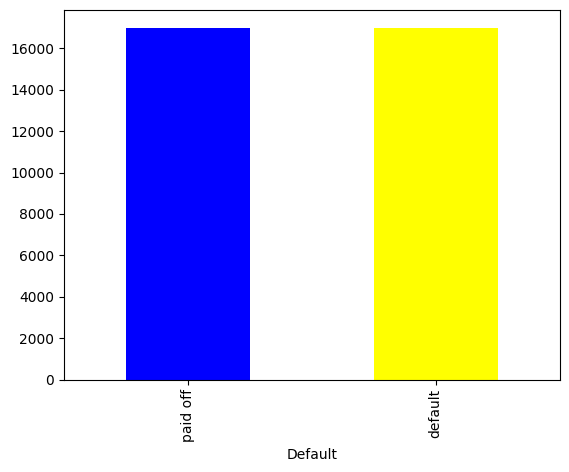

In [4]:
conteo = df.loc[:, 'Default'].value_counts()
print(conteo)
conteo.plot(kind='bar', color=['blue','yellow'])

In [5]:
df.dtypes

Importe                   int64
añosPago                  int64
IngresoAnuales            int64
RelacionIngresoDeuda    float64
RelacionCuotaDeuda      float64
PendienteEnTarjeta        int64
UsoCreditoTarjeta       float64
Objetivo                 object
esPropietario            object
FueVeraz                  int64
TuvoEmbargo               int64
Cuentas                   int64
PuntuacionGeneral       float64
Default                  object
AntiguedadLaboral         int64
dtype: object

In [7]:
#obtengo los valores unicos que contienen las columnas no numericas
print("Default: ",df["Default"].unique())
print("Es propietario: ",df["esPropietario"].unique())
print("Objetivo: ",df["Objetivo"].unique())

#defino las columnas que son categoricas
cat_columns = ["esPropietario","Objetivo"]

encoder=OneHotEncoder(drop=None, sparse_output=False, dtype=int)

encoded = encoder.fit_transform(df[cat_columns]) # Convertir la matriz de valores a un DataFrame
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_columns)) # Unir el DataFrame original con el DataFrame codificado
encoded_df = pd.concat([df, encoded_df], axis=1)
encoded_df = encoded_df.drop(cat_columns, axis=1)
encoded_df['Default'] = encoded_df['Default'].replace({'default': 1, 'paid off': 0})


print(encoded_df)
encoded_df.dtypes

 



Default:  ['paid off' 'default']
Es propietario:  ['Hipoteca' 'Alquiler' 'Propio' 'Otro']
Objetivo:  ['Deuda' 'Deuda renovable' 'Mudanza' 'Evento' 'Hipoteca' 'No declara'
 'Inversion' 'Negocio' 'Bien de Capital' 'Compra' 'Otros' 'Vacaciones']
       Importe  añosPago  IngresoAnuales  RelacionIngresoDeuda  \
0         2000         3           37000                  6.29   
1        28625         5           64000                 15.34   
2        10400         3           76000                 15.11   
3        33425         5           75000                 20.85   
4        15000         5           55000                  7.66   
...        ...       ...             ...                   ...   
34001     5400         3           68000                 15.30   
34002     4800         5           40000                 21.14   
34003    15000         5           62000                  1.55   
34004    20000         3          226000                  6.73   
34005     8000         3       

/tmp/ipykernel_6726/1717496381.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_df['Default'] = encoded_df['Default'].replace({'default': 1, 'paid off': 0})


Importe                       int64
añosPago                      int64
IngresoAnuales                int64
RelacionIngresoDeuda        float64
RelacionCuotaDeuda          float64
PendienteEnTarjeta            int64
UsoCreditoTarjeta           float64
FueVeraz                      int64
TuvoEmbargo                   int64
Cuentas                       int64
PuntuacionGeneral           float64
Default                       int64
AntiguedadLaboral             int64
esPropietario_Alquiler        int64
esPropietario_Hipoteca        int64
esPropietario_Otro            int64
esPropietario_Propio          int64
Objetivo_Bien de Capital      int64
Objetivo_Compra               int64
Objetivo_Deuda                int64
Objetivo_Deuda renovable      int64
Objetivo_Evento               int64
Objetivo_Hipoteca             int64
Objetivo_Inversion            int64
Objetivo_Mudanza              int64
Objetivo_Negocio              int64
Objetivo_No declara           int64
Objetivo_Otros              

<Axes: >

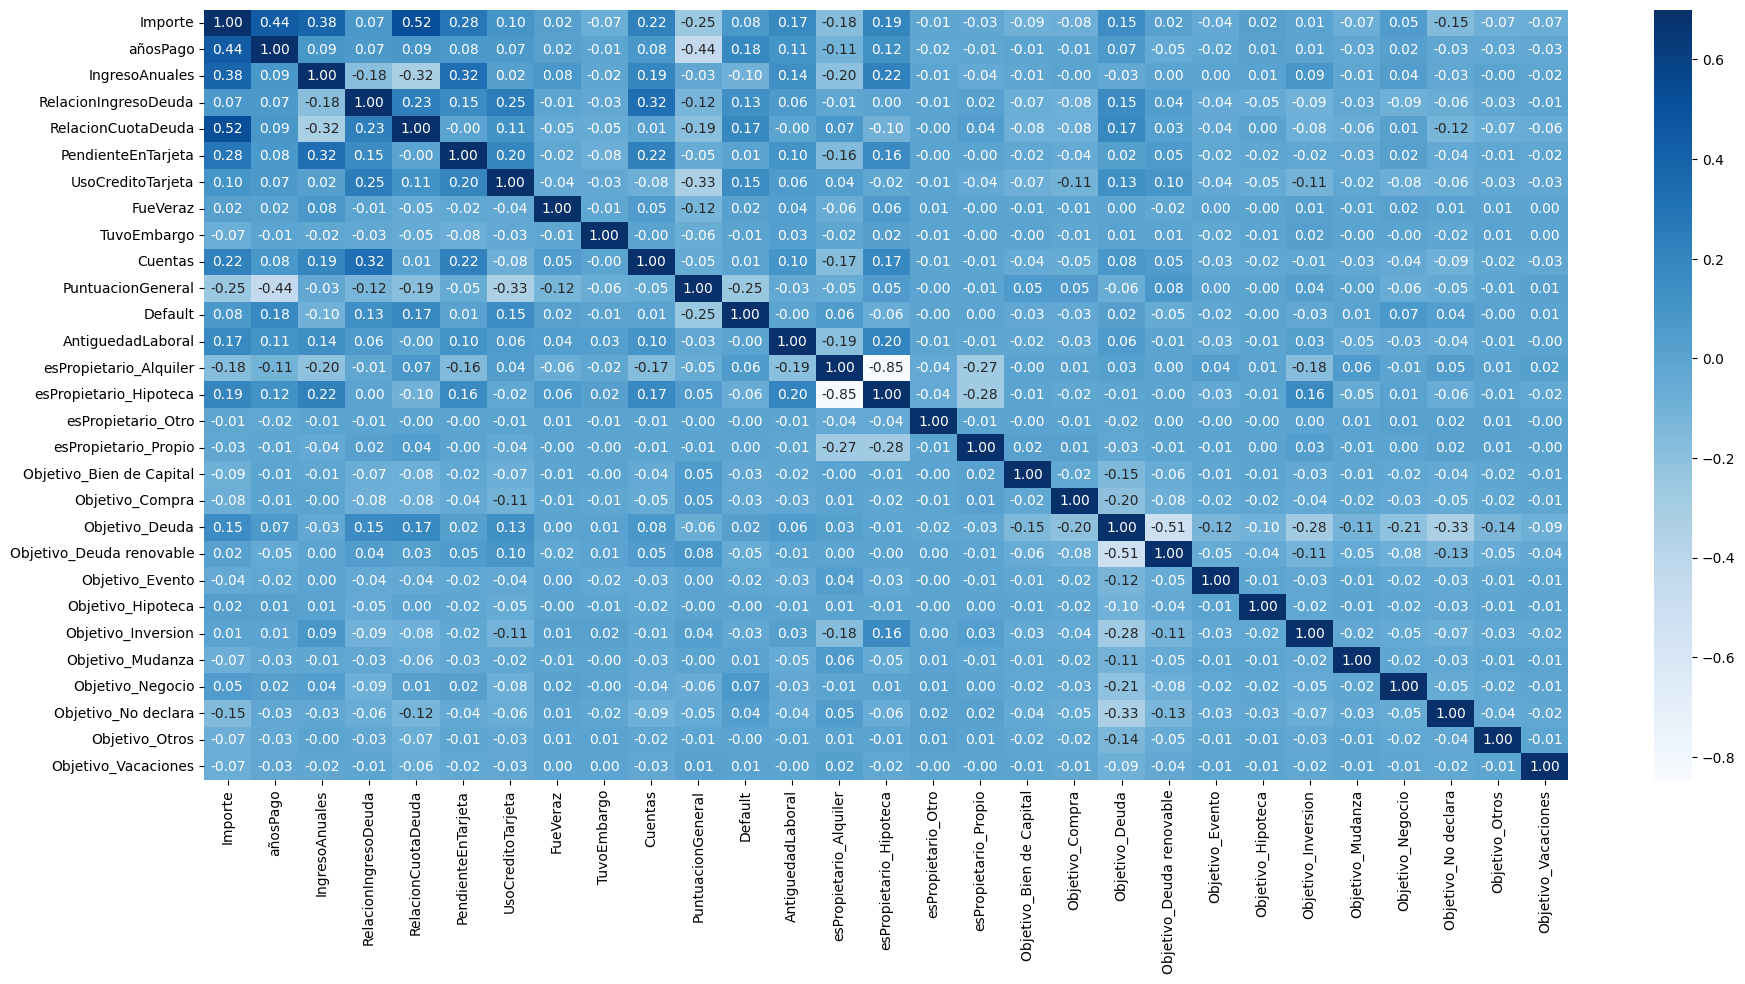

In [9]:
plt.figure(figsize=(22,10))
sns.heatmap(encoded_df.corr(), annot=True, vmax=.7, cmap ='Blues', fmt=".2f")

Nos quedamos con las columnas que tengan una correlación en modulo mayor o igual a 0,1

In [38]:

df_reducido = encoded_df[['Default', 'RelacionIngresoDeuda', 'añosPago','RelacionCuotaDeuda','UsoCreditoTarjeta','IngresoAnuales','PuntuacionGeneral']]
df_reducido.isna().sum()/df_reducido.shape[0]*100

columnas_a_analizar = ['AntiguedadLaboral','Cuentas','TuvoEmbargo','FueVeraz','PendienteEnTarjeta','Importe','RelacionIngresoDeuda', 'añosPago','RelacionCuotaDeuda','UsoCreditoTarjeta','IngresoAnuales','PuntuacionGeneral']

#columnas_a_analizar = ['RelacionCuotaDeuda','PuntuacionGeneral',]

Procesamiento trivial solo para verificar funcionamiento de la plantilla.

In [ ]:
# Atencion: Esto es un ejemplo solo para verificar que la plantilla funciona, remplazar.
X = df.drop(columns='Default')
y = df['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
preprocessor = ColumnTransformer(
    transformers=[
        ('SimpleImputacion', SimpleImputer(), ['añosPago', 'IngresoAnuales']),
    ])
#Pipeline ejemplo
pl = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=20))
])
pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('SimpleImputacion',
                                                  SimpleImputer(),
                                                  ['añosPago',
                                                   'IngresoAnuales'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=20))])

In [15]:
EVALUACION = False
best_clf = pl #Asignar aqui el mejor clasificador posible (previamente entrenado)
#best_clf = pl
#Leemos el dataset de evaluación, simulando producción
if EVALUACION==False:
    df = pd.read_csv(STUDENTDATAFILE)
    _, df = train_test_split(df, test_size=0.3, random_state=42)
else:
    df = pd.read_csv(EVALDATAFILE)
#Dividimos en target y predictoras

X_Eval = df.drop("Default", axis=1)
y_Eval = df["Default"]

#Evaluación final

y_pred = best_clf.predict(X_Eval) # esto debe ser un pipeline completo
print(classification_report(y_Eval, y_pred))

              precision    recall  f1-score   support

     default       0.56      0.53      0.55      5133
    paid off       0.55      0.58      0.56      5069

    accuracy                           0.56     10202
   macro avg       0.56      0.56      0.56     10202
weighted avg       0.56      0.56      0.56     10202



-----------------------------------KNN----------------------------------------------

In [13]:
# Atencion: Esto es un ejemplo solo para verificar que la plantilla funciona, remplazar.
X = df_reducido.drop(columns='Default')
y = df_reducido['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
preprocessor = ColumnTransformer(
    transformers=[
        ('SimpleImputacion', SimpleImputer(), ['añosPago', 'IngresoAnuales']),
    ])
#Pipeline ejemplo
pl = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=20))
])
pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('SimpleImputacion',
                                                  SimpleImputer(),
                                                  ['añosPago',
                                                   'IngresoAnuales'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=20))])

In [ ]:
# Atencion: Esto es un ejemplo solo para verificar que la plantilla funciona, remplazar.
X = df_reducido.drop(columns='Default')
y = df_reducido['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
preprocessor = ColumnTransformer(
    transformers=[
        ('StandardScaler', StandardScaler(), ['RelacionIngresoDeuda', 'añosPago','RelacionCuotaDeuda','UsoCreditoTarjeta','IngresoAnuales','PuntuacionGeneral']),
    ])
#Pipeline ejemplo
pl = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=13))
])
pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  ['añosPago',
                                                   'RelacionCuotaDeuda',
                                                   'UsoCreditoTarjeta',
                                                   'PuntuacionGeneral'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=13))])

In [35]:
# Atencion: Esto es un ejemplo solo para verificar que la plantilla funciona, remplazar.
X = df_reducido.drop(columns='Default')
y = df_reducido['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
preprocessor = ColumnTransformer(
    transformers=[
        ('StandardScaler', StandardScaler(), columnas_a_analizar),
    ])
#Pipeline ejemplo
pl = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=15))
])
pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  ['RelacionCuotaDeuda',
                                                   'UsoCreditoTarjeta',
                                                   'PuntuacionGeneral',
                                                   'añosPago'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=15))])

In [39]:
# Atencion: Esto es un ejemplo solo para verificar que la plantilla funciona, remplazar.
X = encoded_df.drop(columns='Default')
y = encoded_df['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
preprocessor = ColumnTransformer(
    transformers=[
        ('StandardScaler', StandardScaler(), columnas_a_analizar),
    ])
#Pipeline ejemplo
pl = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=15))
])
pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  ['AntiguedadLaboral',
                                                   'Cuentas', 'TuvoEmbargo',
                                                   'FueVeraz',
                                                   'PendienteEnTarjeta',
                                                   'Importe',
                                                   'RelacionIngresoDeuda',
                                                   'añosPago',
                                                   'RelacionCuotaDeuda',
                                                   'UsoCreditoTarjeta',
                                                   'IngresoAnuales',
                                                   'PuntuacionGeneral'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=15))])

In [ ]:
y_pred = pl.predict(X_test) # esto debe ser un pipeline completo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.64      0.62      4745
           1       0.63      0.60      0.62      4954

    accuracy                           0.62      9699
   macro avg       0.62      0.62      0.62      9699
weighted avg       0.62      0.62      0.62      9699



--------------------------------- ARBOL ------------------------------------------

TypeError: DecisionTreeClassifier.__init__() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given

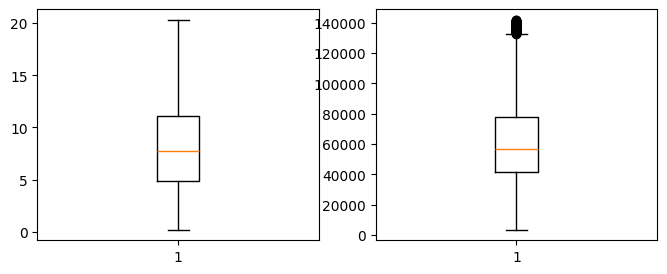

In [ ]:
param_grid = {'max_depth': [3, 5, 10],'min_samples_split': [2, 5, 10],'criterion': ['gini', 'entropy'] }

bxColumns = ['RelacionCuotaDeuda','IngresoAnuales']
fig, axs = plt.subplots(1, len(bxColumns), figsize=(8, 3))
for c,i in zip(bxColumns, range(len(bxColumns))):
    axs[i].boxplot(encoded_df[c])

df_reducido = encoded_df[['Default', 'RelacionIngresoDeuda', 'añosPago','RelacionCuotaDeuda','IngresoAnuales','Importe','UsoCreditoTarjeta','PuntuacionGeneral']]

# Atencion: Esto es un ejemplo solo para verificar que la plantilla funciona, remplazar.
X = df_reducido.drop(columns='Default')
y = df_reducido['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
preprocessor = ColumnTransformer(
    transformers=[
        ('StandardScaler', StandardScaler(), ['RelacionIngresoDeuda','Importe','añosPago','RelacionCuotaDeuda','UsoCreditoTarjeta','IngresoAnuales','PuntuacionGeneral']),
    ])
#Pipeline ejemplo
pl = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier',  DecisionTreeClassifier(max_depth=5,random_state=42))
])
pl.fit(X_train, y_train)

In [59]:
# 1. Preparar datos

X = encoded_df.drop(columns=['Default'])
y = encoded_df['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 
# 2. Crear pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeClassifier(random_state=42))
])
 
# 3. Ajustar hiperparámetros
param_grid = {
    'model__max_depth': [3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
 
# 4. Evaluar modelo optimizado
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)
print(f"Precisión optimizada: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Precisión optimizada: 0.6294463346736777
              precision    recall  f1-score   support

           0       0.63      0.59      0.61      4745
           1       0.63      0.66      0.65      4954

    accuracy                           0.63      9699
   macro avg       0.63      0.63      0.63      9699
weighted avg       0.63      0.63      0.63      9699



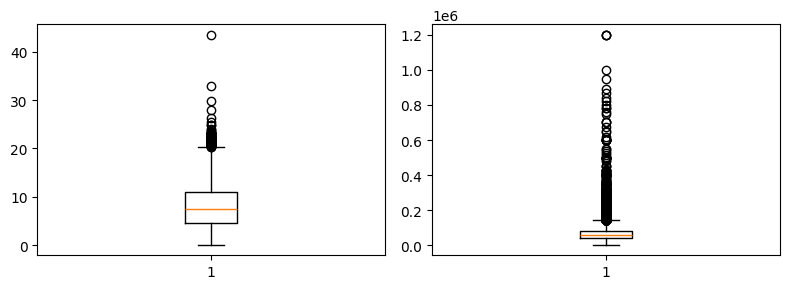

/tmp/ipykernel_6726/2004762646.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  encoded_df = encoded_df[(df[c]<LS) & (df[c]>LI)]


In [21]:
bxColumns = ['RelacionCuotaDeuda','IngresoAnuales']
fig, axs = plt.subplots(1, len(bxColumns), figsize=(8, 3))
for c,i in zip(bxColumns, range(len(bxColumns))):
    axs[i].boxplot(encoded_df[c])
   
plt.tight_layout()
plt.show()
remove_outliers = True
if remove_outliers:
    for c in bxColumns:
        if("float" in str(encoded_df.dtypes[c]) or "int" in str(encoded_df.dtypes[c])):
            Q1 = encoded_df[c].quantile(0.25)
            Q3 = encoded_df[c].quantile(0.75)
            IQR = Q3-Q1
            LI = Q1 - 1.5 * IQR
            LS = Q3 + 1.5 * IQR
            encoded_df = encoded_df[(df[c]<LS) & (df[c]>LI)]

In [65]:
# Función para imputar outliers con la media en todo el DataFrame
def imputar_outliers_todo_df(df, method='iqr', threshold=1.5):

    df = df.copy()  # Crear una copia para evitar modificar el original

    # Iterar sobre todas las columnas numéricas
    for column in df.select_dtypes(include=[np.number]).columns:
        col = df[column]

        # Calcular límites según el método seleccionado
        if method == 'iqr':
            Q1 = col.quantile(0.25)
            Q3 = col.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
        elif method == 'std':
            mean = col.mean()
            std = col.std()
            lower_bound = mean - threshold * std
            upper_bound = mean + threshold * std
        else:
            raise ValueError("Método no reconocido. Usa 'iqr' o 'std'.")

        # Identificar y reemplazar outliers
        outliers = (col < lower_bound) | (col > upper_bound)
        df.loc[outliers, column] = col.mean()
    
    return df

# Imputar outliers en todo el DataFrame
imputed_df = imputar_outliers_todo_df(encoded_df, method='iqr')


/tmp/ipykernel_6726/524687118.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12793.054223761948' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outliers, column] = col.mean()
/tmp/ipykernel_6726/524687118.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.500726901543506' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outliers, column] = col.mean()
/tmp/ipykernel_6726/524687118.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '61672.02350830524' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outliers, column] = col.mean()
/tmp/ipykernel_6726/524687118.py:27: FutureWarning: Setting an 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  ['RelacionIngresoDeuda',
                                                   'Importe', 'añosPago',
                                                   'RelacionCuotaDeuda',
                                                   'UsoCreditoTarjeta',
                                                   'IngresoAnuales',
                                                   'PuntuacionGeneral'])])),
                ('classifier', LogisticRegression())])

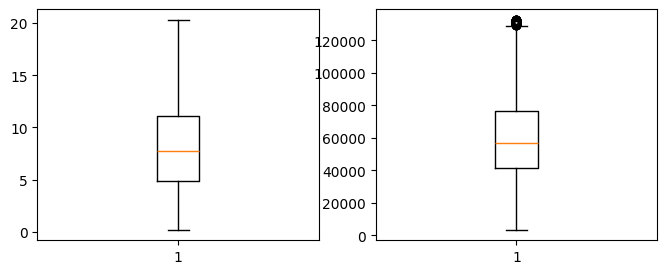

In [66]:
bxColumns = ['RelacionCuotaDeuda','IngresoAnuales']
fig, axs = plt.subplots(1, len(bxColumns), figsize=(8, 3))
for c,i in zip(bxColumns, range(len(bxColumns))):
    axs[i].boxplot(imputed_df[c])

df_reducido = imputed_df[['Default', 'RelacionIngresoDeuda', 'añosPago','RelacionCuotaDeuda','IngresoAnuales','Importe','UsoCreditoTarjeta','PuntuacionGeneral']]

# Atencion: Esto es un ejemplo solo para verificar que la plantilla funciona, remplazar.
X = df_reducido.drop(columns='Default')
y = df_reducido['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
preprocessor = ColumnTransformer(
    transformers=[
        ('StandardScaler', StandardScaler(), ['RelacionIngresoDeuda','Importe','añosPago','RelacionCuotaDeuda','UsoCreditoTarjeta','IngresoAnuales','PuntuacionGeneral']),
    ])
#Pipeline ejemplo
pl = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier',  LogisticRegression())
])
pl.fit(X_train, y_train)

In [67]:
y_pred = pl.predict(X_test) # esto debe ser un pipeline completo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.62      0.65      0.64      4745
         1.0       0.65      0.63      0.64      4954

    accuracy                           0.64      9699
   macro avg       0.64      0.64      0.64      9699
weighted avg       0.64      0.64      0.64      9699

